In [365]:
import numpy as np
import scipy.stats as s
import configparser
import pandas as pd
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10, 6)
import matplotlib.pyplot as plt
import scipy.stats as ss

from nltk import word_tokenize
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/marat/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [366]:
config = configparser.ConfigParser()
config.read('bot.ini')
config = config['DEFAULT']

# data = pd.read_csv(config['out_tsv'], sep='\t')
data = pd.read_csv('target/sber3_w_random.tsv', sep='\t')

In [367]:
def plot_beta(bot, human, rnd, title='', legend=True):
    neg, pos = bot
    x = np.linspace(ss.beta.ppf(0.01, pos, neg), ss.beta.ppf(0.99, pos, neg), 100)
    label = 'bot {}/({}+{})={:.2f}'.format(pos, neg, pos, pos/(neg+pos))
    plt.plot(x, ss.beta.pdf(x, pos, neg), 'r-', lw=5, alpha=0.6, label=label)

    neg, pos = human
    x = np.linspace(ss.beta.ppf(0.01, pos, neg), ss.beta.ppf(0.99, pos, neg), 100)
    label = 'human {}/({}+{})={:.2f}'.format(pos, neg, pos, pos/(neg+pos))
    plt.plot(x, ss.beta.pdf(x, pos, neg), 'g-', lw=5, alpha=0.6, label=label)
       
    neg, pos = rnd
    x = np.linspace(ss.beta.ppf(0.01, pos, neg), ss.beta.ppf(0.99, pos, neg), 100)
    label = 'random {}/({}+{})={:.2f}'.format(pos, neg, pos, pos/(neg+pos))
    plt.plot(x, ss.beta.pdf(x, pos, neg), 'b-', lw=5, alpha=0.6, label=label)
    
    
    ztest = sm.stats.proportions_ztest([bot[1], human[1]], [sum(bot), sum(human)], alternative='two-sided')
    plt.title('{} (Fisher test z={:.3f}, pvalue={:.4f})'.format(title, *ztest))
    if legend:
        plt.legend()
    plt.xlim(0, 1)

In [368]:
def compare(data, eps=1e-2):
    res = {}
    for g, d in data.groupby(['operator', 'is_meaningful']):
        x = d['answer'].apply(lambda x: len(word_tokenize(x)))
        res[g] = (x > 7).sum()
#         res[g] = len(d)

    bot = [res.get(('bot', 0), eps), res.get(('bot', 1), eps)]
    human = [res.get(('human', 0), eps), res.get(('human', 1), eps)]
    rnd = [res.get(('random', 0), eps), res.get(('random', 1), eps)]

    chi = s.chisquare(bot, f_exp=human)
    ztest = sm.stats.proportions_ztest([bot[1], human[1]], [sum(bot), sum(human)], alternative='two-sided')
    
    return [chi.pvalue, ztest], [bot, human, rnd], human[1] / (human[0] + human[1]), bot[1] / (bot[1] + bot[0]), rnd[1] / (rnd[1] + rnd[0])

Index(['chat_id', 'user', 'question_id', 'operator', 'question', 'answer',
       'time_asked', 'time_answered', 'is_meaningful', 'discriminator_score'],
      dtype='object')
overall 577 ([1.7652377764448522e-10, (-4.1930020692980277, 2.7528693119287942e-05)], [[78, 106], [44, 153], [108, 58]], 0.7766497461928934, 0.57608695652173914, 0.3493975903614458)


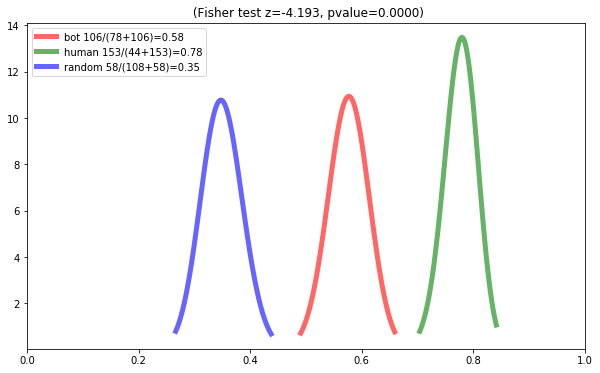

In [369]:
print(data.columns)

c = compare(data)
print('overall', len(data), c)

_, [bot, human, rnd], *_2 = c
plot_beta(bot, human, rnd)
plt.show()

Aleksey@yoptar 40 ([1.7652377764448522e-10, (-4.1930020692980277, 2.7528693119287942e-05)], [[78, 106], [44, 153], [108, 58]], 0.7766497461928934, 0.57608695652173914, 0.3493975903614458)
Alexey@ 57 ([1.7652377764448522e-10, (-4.1930020692980277, 2.7528693119287942e-05)], [[78, 106], [44, 153], [108, 58]], 0.7766497461928934, 0.57608695652173914, 0.3493975903614458)
Anatoly@anatoliipotapov 54 ([1.7652377764448522e-10, (-4.1930020692980277, 2.7528693119287942e-05)], [[78, 106], [44, 153], [108, 58]], 0.7766497461928934, 0.57608695652173914, 0.3493975903614458)
Dilyara@bdilya 69 ([1.7652377764448522e-10, (-4.1930020692980277, 2.7528693119287942e-05)], [[78, 106], [44, 153], [108, 58]], 0.7766497461928934, 0.57608695652173914, 0.3493975903614458)
Eugeniya 🐙@fogside 50 ([1.7652377764448522e-10, (-4.1930020692980277, 2.7528693119287942e-05)], [[78, 106], [44, 153], [108, 58]], 0.7766497461928934, 0.57608695652173914, 0.3493975903614458)
Leonid@leonidpugachev 30 ([1.7652377764448522e-10, (-4

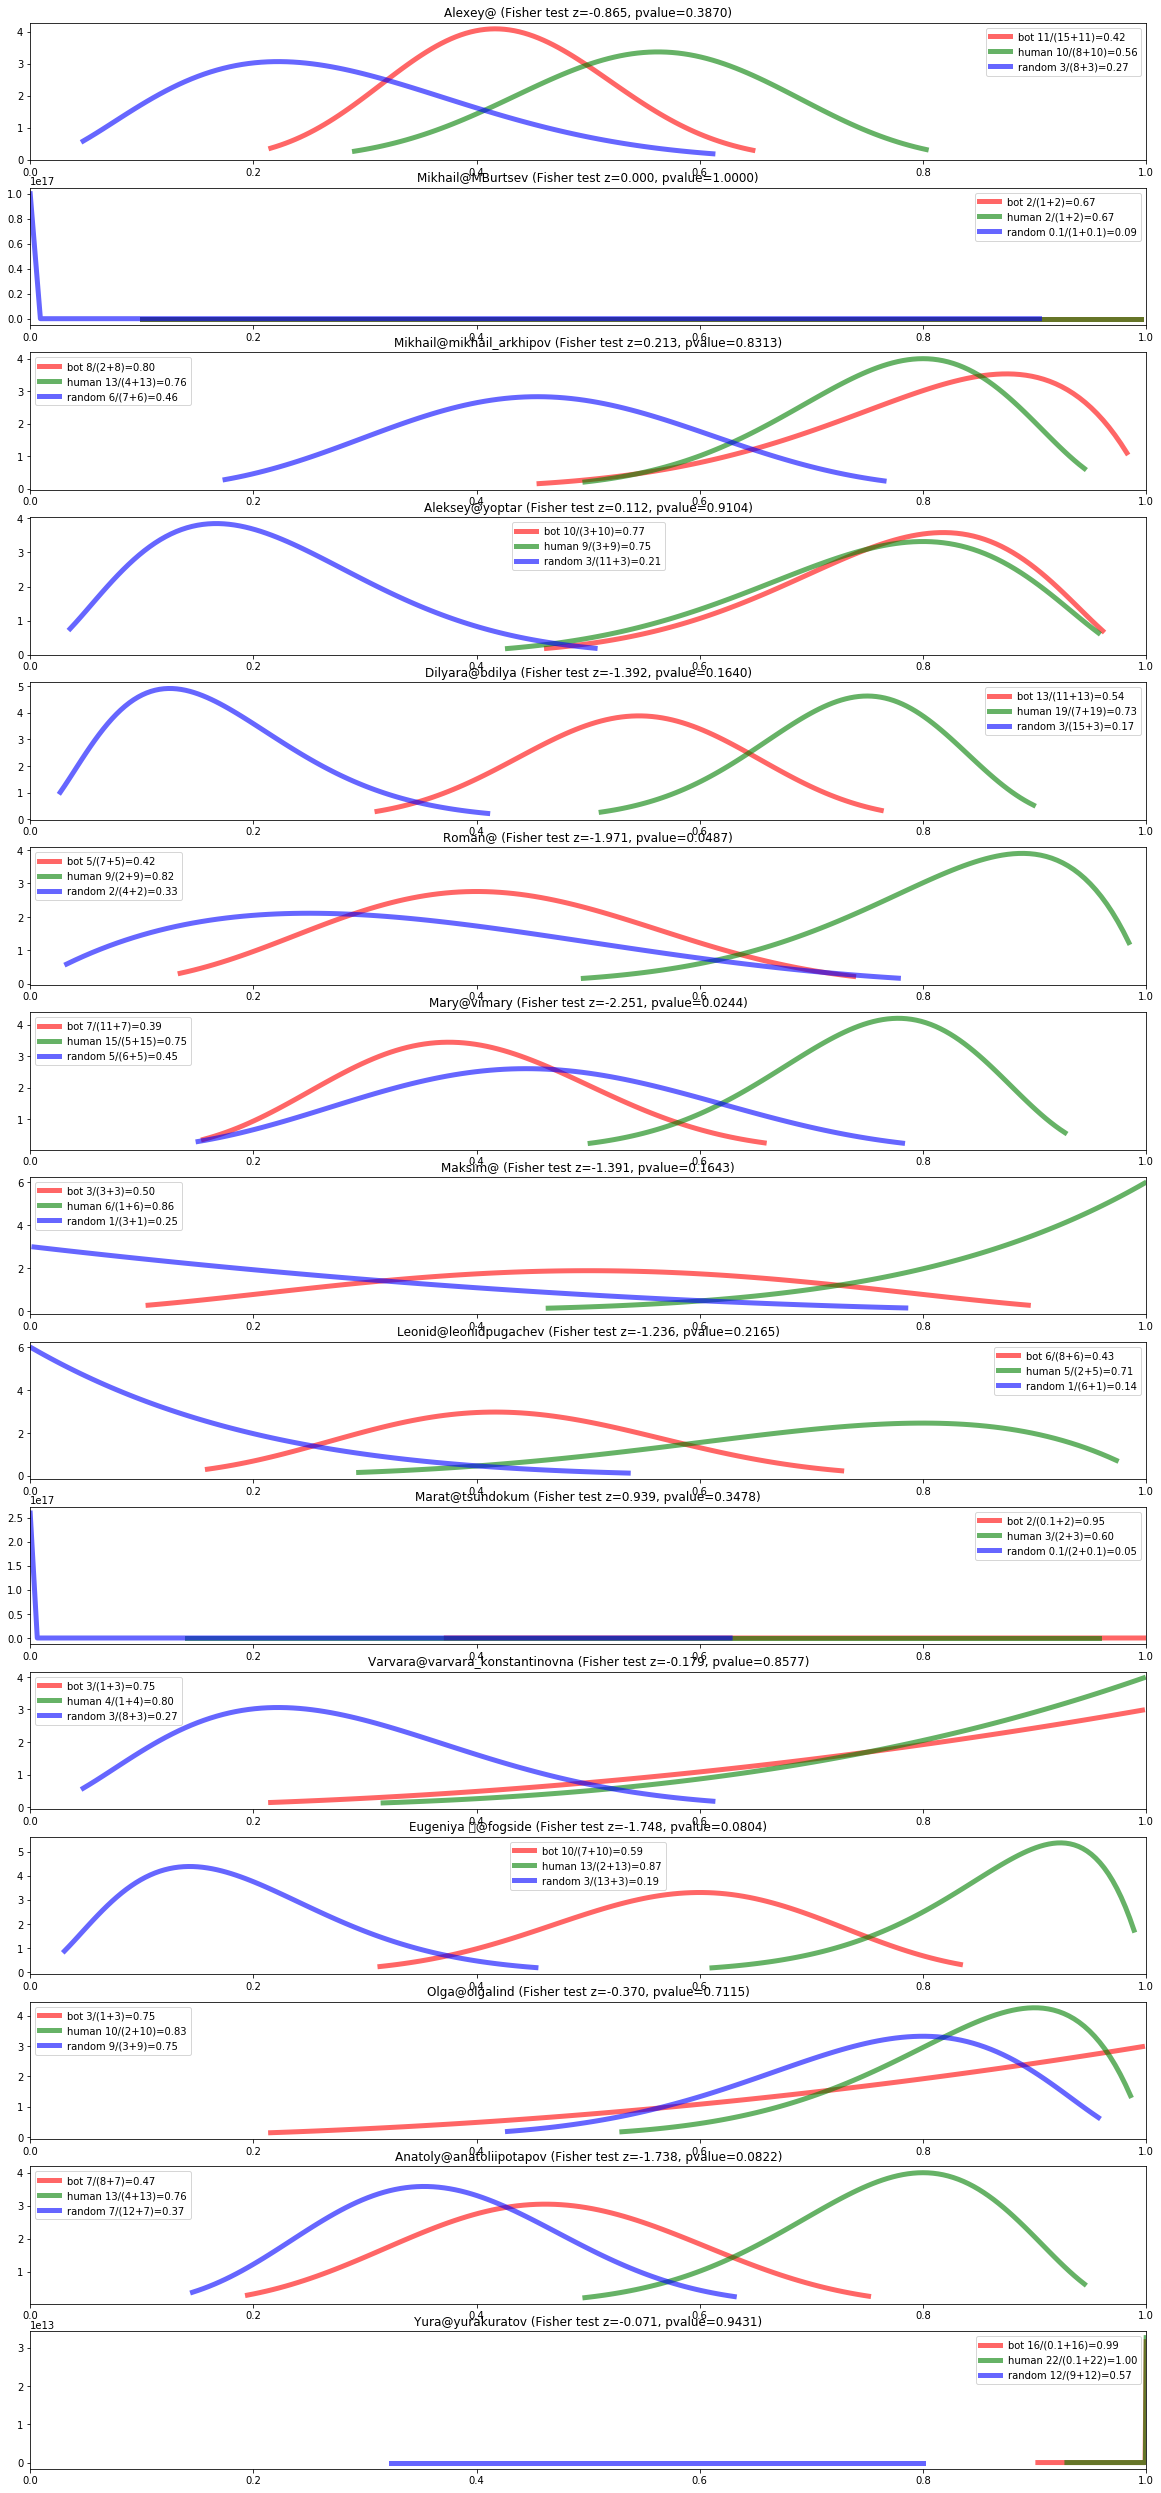

In [370]:
order = {c: i for i, c in enumerate(data['user'].unique())}

plt.figure(figsize=(20, len(order)*3))
for g, d in data.groupby('user'):
    try:
        _, [bot, human, rnd], *__ = compare(d, eps=0.1)
        plt.subplot(len(order), 1, order[g]+1)
        plot_beta(bot, human, rnd, title=g, legend=True)
        print(g, len(d), c)
    except KeyError as ex:
        print(ex)
    except ZeroDivisionError:
        print('\t>>> Not enough data for {}'.format(g))
plt.show()

In [360]:
data.head()

,chat_id,user,question_id,operator,question,answer,time_asked,time_answered,is_meaningful,discriminator_score,newbie
0,163008481,Alexey@,5268,human,Здравствуйте ! Вопрос я задал выше,"Андрей Михайлович , Вы работаете в системе E...",2017-11-17T11:45:46.689332,2017-11-17T11:45:55.455236,0,0.37124836444854736,expert
1,250566022,Mikhail@MBurtsev,30089,human,Как перейти на старую версию ?,"Алексей Васильевич , если у Вас есть замечани...",2017-11-17T11:44:33.285059,2017-11-17T11:45:57.336771,0,0.4077756702899933,expert
2,314318558,Mikhail@mikhail_arkhipov,2658,human,Я ХОЧУ ВЕРНУТЬ СТАРЫЙ ДИЗАЙН . МНЕ ЭТОТ НЕ НРА...,"Служба технической поддержки Сбербанка , мен...",2017-11-17T11:45:55.679836,2017-11-17T11:46:02.587337,1,0.5677672624588013,expert
3,163008481,Alexey@,26190,human,При подписи реестра пишет не определена сим карта,"Дмитрий Сергеевич , у вас ошибка выходит при...",2017-11-17T11:45:55.455421,2017-11-17T11:46:05.219326,0,0.9300136566162109,expert
4,314318558,Mikhail@mikhail_arkhipov,35622,random,ещё раз добрый день !,Благодарим Вас за обращение в Службу техниче...,2017-11-17T11:46:02.587580,2017-11-17T11:46:09.102856,0,None,expert


In [361]:

# for g, d in data.groupby('score_class'):
#     try:
#         c = compare(d)
#         print(g, len(d))
#         _, [bot, human, rnd], *_2 = c
#         plt.subplot(2, 1, g+1)
#         plot_beta(bot, human, rnd, title='Discriminator Class {}'.format(g))
#     except KeyError as ex:
#         pass
# plt.show()

In [362]:

sm.stats.proportions_ztest([117, 244], [117+33, 244+83], alternative='two-sided')


(0.79947239784001334, 0.42401654545138667)

In [363]:
data.user.unique()

array(['Alexey@', 'Mikhail@MBurtsev', 'Mikhail@mikhail_arkhipov',
       'Aleksey@yoptar', 'Dilyara@bdilya', 'Roman@', 'Mary@vimary',
       'Maksim@', 'Leonid@leonidpugachev', 'Marat@tsundokum',
       'Varvara@varvara_konstantinovna', 'Eugeniya 🐙@fogside',
       'Olga@olgalind', 'Anatoly@anatoliipotapov', 'Yura@yurakuratov'], dtype=object)

expert 412
newbie 165


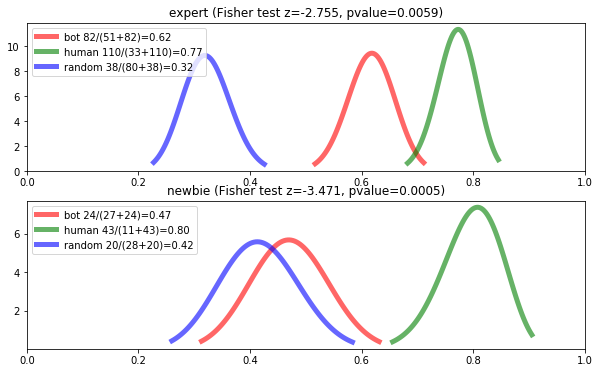

In [364]:
exp_users = ['Alexey@', 'Mikhail@MBurtsev', 'Mikhail@mikhail_arkhipov',
       'Aleksey@yoptar', 'Dilyara@bdilya', 'Mary@vimary',
       'Marat@tsundokum', 'Varvara@varvara_konstantinovna', 'Eugeniya 🐙@fogside',
            'Yura@yurakuratov']
new_users = ['Roman@', 'Maksim@', 'Leonid@leonidpugachev', 'Olga@olgalind', 'Anatoly@anatoliipotapov']

def newbie(username):
    if username in new_users:
        return 'newbie'
    elif username in exp_users:
        return 'expert'
    else:
        return 'unknown'


data['newbie'] = data['user'].apply(newbie)

order = {c: i for i, c in enumerate(data['newbie'].unique())}

for g, d in data.groupby('newbie'):
    try:
        c = compare(d)
        _, [bot, human, rnd], *_2 = c
        print(g, len(d), )
        plt.subplot(2, 1, order[g]+1)
        plot_beta(bot, human, rnd, title=g)
    except KeyError as ex:
        print(ex)
plt.show()        